<a href="https://colab.research.google.com/github/HanaeELMEKKI/COMP-6321-Assignment-1/blob/main/Question4/Implementation_Question4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise Description:**
Design and implement a CNN to be used in a task of Medical Image Classification. Given an image of an MRI/CT/X-ray scan, your model is to predict the
body part being scanned. Some sample images are shown in the figure below.
You should use and download the dataset from Kaggle, which you can reduce
to 1000 data points per class. You are required to split the data into train and
test sets with 7:3 ratio. You should design and build a simple CNN using PyTorch, and train it on the given dataset for 10 epochs. Report on your design,
your choice of hyperparameters, as well as the training accuracy/loss plots.
You can use scikit-learn’s classification report tool for numerical analysis.


In [ ]:
!wget "https://raw.githubusercontent.com/HanaeELMEKKI/COMP-6321-Assignment-1/main/Question4/dataset_medical_mnist.zip"
!unzip "dataset_medical_mnist.zip";

In [8]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
import numpy as np
from prettytable import PrettyTable

#train and test data directory
data_dir = "/content/dataset_medical_mnist"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.ToTensor()
]))

img, label = dataset[0]
print(img.shape,label)

print("Follwing classes are there : \n",dataset.classes)

torch.Size([3, 64, 64]) 0
Follwing classes are there : 
 ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


In [30]:
#Split dataset
train_set,test_set = torch.utils.data.random_split(dataset,[0.7,0.3])

train_loader = DataLoader(train_set,shuffle=True,batch_size=50)
test_loader = DataLoader(test_set,shuffle=True,batch_size=50)

In [36]:
#Model
torch.manual_seed(0)
model = nn.Sequential(

          nn.Conv2d(3,32,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),

          nn.Conv2d(32,64,kernel_size=3,padding=1),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(2,2),

          nn.Conv2d(64,128,kernel_size=3,padding=1),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(2,2),

          nn.Conv2d(128,256,kernel_size=3,padding=1),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(2,2),

          nn.Flatten(),

          nn.Linear(4096,50), #50x4096
          torch.nn.ReLU(),
          nn.Linear(50,25), #50x4096
          torch.nn.ReLU(),
          torch.nn.Linear(25,6)
        )

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [38]:
#Train the model
loss = nn.CrossEntropyLoss()
num_epoch = 10
next_epoch = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_history = []
accuracy_history = []
for epoch in range(next_epoch, next_epoch+num_epoch):

    train_losses = []
    train_accuracies = []
    for batch in train_loader:
        images, labels = batch

        label_pred = model(images)
        l = loss(label_pred,labels)
        train_losses.append(l)

        train_accuracies.append(accuracy(label_pred,labels))
        model.zero_grad()
        l.backward()
        optimizer.step()

    accuracy_history.append(torch.stack(train_accuracies).mean().item())
    loss_history.append(torch.stack(train_losses).mean().item())

    print("Epoch %2d: loss on final training batch: %.6f" % (epoch, l.item()))

next_epoch = epoch+1

Epoch  1: loss on final training batch: 1.776958
Epoch  2: loss on final training batch: 0.269922
Epoch  3: loss on final training batch: 0.128843
Epoch  4: loss on final training batch: 0.009242
Epoch  5: loss on final training batch: 0.111648
Epoch  6: loss on final training batch: 0.001065
Epoch  7: loss on final training batch: 0.052232
Epoch  8: loss on final training batch: 0.029015
Epoch  9: loss on final training batch: 0.001131
Epoch 10: loss on final training batch: 0.009741


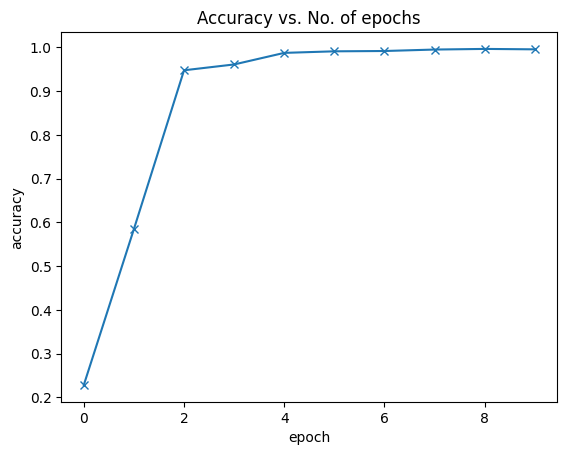

In [39]:
def plot_accuracies(accuracy_history):
    """ Plot the history of accuracies"""
    plt.plot(accuracy_history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(accuracy_history)

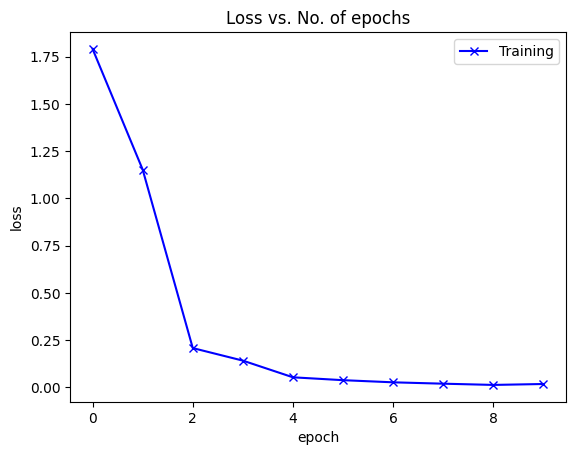

In [40]:
def plot_losses(loss_history):
    """ Plot the losses in each epoch"""
    plt.plot(loss_history, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training'])
    plt.title('Loss vs. No. of epochs');

plot_losses(loss_history)

In [42]:
#Classification Report
table = PrettyTable(zero_division=False)
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]

test_predictions = []
test_true_labels = []
for batch in test_loader:
        images, labels = batch
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

report = sklearn.metrics.classification_report(test_true_labels, test_predictions, output_dict=True)
for label, metrics in report.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    table.add_row([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])

print(f'Classification report: ', {table})

Classification report:  {+-------+--------------------+--------------------+--------------------+---------+
| Class |     Precision      |       Recall       |      F1-Score      | Support |
+-------+--------------------+--------------------+--------------------+---------+
|   0   |        1.0         |        1.0         |        1.0         |   308   |
|   1   |        1.0         |        1.0         |        1.0         |   298   |
|   2   | 0.9927007299270073 | 0.9819494584837545 | 0.9872958257713249 |   277   |
|   3   |        1.0         |        1.0         |        1.0         |   328   |
|   4   | 0.9716312056737588 | 0.9927536231884058 | 0.9820788530465949 |   276   |
|   5   |        1.0         | 0.9904153354632588 | 0.9951845906902087 |   313   |
+-------+--------------------+--------------------+--------------------+---------+}
